In [10]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna

In [11]:
data_path = './data/'
df = pd.read_csv(data_path + 'trainData.csv')

#To DROP NAXUI:
to_drop = ['NameV', 'EmbarkedQ', 'SibSp']
df.drop(to_drop, axis=1, inplace=True)
#df = df[[*to_drop] + ['Survived']]


X = df.drop('Survived', axis=1)
y = df.Survived

X_train, X_test_general, y_train, y_test_general = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.head()

,Pclass,Age,Parch,Fare,SexQ
298,1,28.00,0,34.177267,0
884,3,25.00,0,19.530276,0
247,2,24.00,2,26.741486,1
478,3,22.00,0,20.176725,0
305,1,0.92,2,50.209156,0


In [24]:
#GRIDSEARCH OPTIMIZATION
model = CatBoostClassifier()
params_grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'od_wait' : [3, 5, 10, 15]
        }
grid_search_res = model.grid_search(params_grid, X_train, y_train)
grid_search_res['params'] # HERE BEST PARAMS

g detector  (3 iterations wait)

bestTest = 0.4279095546
bestIteration = 62

2:	loss: 0.4279096	best: 0.4221498 (1)	total: 162ms	remaining: 6.33s
Stopped by overfitting detector  (3 iterations wait)

bestTest = 0.4165546357
bestIteration = 28

3:	loss: 0.4165546	best: 0.4165546 (3)	total: 179ms	remaining: 5.2s
Stopped by overfitting detector  (3 iterations wait)

bestTest = 0.4391395421
bestIteration = 58

4:	loss: 0.4391395	best: 0.4165546 (3)	total: 212ms	remaining: 4.88s
Stopped by overfitting detector  (3 iterations wait)

bestTest = 0.4255204105
bestIteration = 25

5:	loss: 0.4255204	best: 0.4165546 (3)	total: 228ms	remaining: 4.33s
Stopped by overfitting detector  (3 iterations wait)

bestTest = 0.4375531411
bestIteration = 63

6:	loss: 0.4375531	best: 0.4165546 (3)	total: 262ms	remaining: 4.22s
Stopped by overfitting detector  (3 iterations wait)

bestTest = 0.4243762069
bestIteration = 22

7:	loss: 0.4243762	best: 0.4165546 (3)	total: 276ms	remaining: 3.87s
Stopped by overfitti

{'depth': 6, 'od_wait': 5, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [26]:
#OPTUNA OPTIMIZATION
def objective(trial):
    X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    op_params = {'iterations': trial.suggest_int('iterations', 50, 1000),
                'depth': trial.suggest_int('depth', 2, 7),
                'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 5, 20),
                'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 0, 100),
                'od_wait': trial.suggest_int('od_wait', 4, 15),
                'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.1)
                  }

    model = CatBoostClassifier(**op_params)
    model.fit(X_train_l, y_train_l)

    preds = model.predict(X_test_l)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test_l, pred_labels)
    return accuracy
  
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

#BEST PARAMS HERE
trial = study.best_trial
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


ms	remaining: 431ms
574:	learn: 0.3292311	total: 661ms	remaining: 430ms
575:	learn: 0.3292210	total: 662ms	remaining: 429ms
576:	learn: 0.3292106	total: 663ms	remaining: 428ms
577:	learn: 0.3292006	total: 664ms	remaining: 426ms
578:	learn: 0.3291968	total: 665ms	remaining: 425ms
579:	learn: 0.3291909	total: 666ms	remaining: 423ms
580:	learn: 0.3291799	total: 666ms	remaining: 422ms
581:	learn: 0.3289267	total: 667ms	remaining: 421ms
582:	learn: 0.3287751	total: 668ms	remaining: 420ms
583:	learn: 0.3285978	total: 669ms	remaining: 418ms
584:	learn: 0.3284023	total: 670ms	remaining: 417ms
585:	learn: 0.3283166	total: 671ms	remaining: 416ms
586:	learn: 0.3283124	total: 672ms	remaining: 414ms
587:	learn: 0.3282948	total: 673ms	remaining: 413ms
588:	learn: 0.3281409	total: 674ms	remaining: 412ms
589:	learn: 0.3280318	total: 675ms	remaining: 411ms
590:	learn: 0.3280141	total: 676ms	remaining: 409ms
591:	learn: 0.3280053	total: 677ms	remaining: 408ms
592:	learn: 0.3279010	total: 678ms	remaining

In [18]:
#RANDOMIZED SEARCH CV
model = CatBoostClassifier()
params_rand = {'iterations': [200, 500, 700, 1000],
          'depth': [x for x in range(4, 10)],
          'l2_leaf_reg': [x for x in range(0, 100)],
          'leaf_estimation_iterations': [5, 10, 15, 20],
          'early_stopping_rounds': [5, 10, 20, 30],
          'learning_rate': [0.03, 0.1]}
random_search_res = model.randomized_search(params_rand, X_train, y_train)
random_search_res['params'] # HERE BEST PARAMS

Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4440775258
bestIteration = 66

0:	loss: 0.4440775	best: 0.4440775 (0)	total: 143ms	remaining: 1.28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4313665043
bestIteration = 152

1:	loss: 0.4313665	best: 0.4313665 (1)	total: 252ms	remaining: 1.01s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4392121805
bestIteration = 119

2:	loss: 0.4392122	best: 0.4313665 (1)	total: 393ms	remaining: 916ms
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4368034541
bestIteration = 184

3:	loss: 0.4368035	best: 0.4313665 (1)	total: 543ms	remaining: 814ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.4229898615
bestIteration = 133

4:	loss: 0.4229899	best: 0.4229899 (4)	total: 728ms	remaining: 728ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.4386687731
bestIteration = 91

5:	loss: 0.4386688	best: 0.4229899 (4)	total: 897ms	remaini

{'leaf_estimation_iterations': 10,
 'depth': 7,
 'od_wait': 10,
 'l2_leaf_reg': 16,
 'iterations': 1000,
 'learning_rate': 0.03}

In [35]:
# ACCURACY SCORE

#best_model = CatBoostClassifier(**grid_search_res['params'])
#best_model = CatBoostClassifier(**trial.params)
best_model = CatBoostClassifier(**random_search_res['params'])

best_model.fit(X = X_train, y = y_train)
chek_preds = best_model.predict(X_test_general)
print(  accuracy_score(chek_preds, y_test_general)  )
f1_score(chek_preds, y_test_general)

total: 1.7s	remaining: 1.06s
616:	learn: 0.2669905	total: 1.7s	remaining: 1.06s
617:	learn: 0.2669442	total: 1.71s	remaining: 1.06s
618:	learn: 0.2667034	total: 1.71s	remaining: 1.05s
619:	learn: 0.2666126	total: 1.71s	remaining: 1.05s
620:	learn: 0.2665910	total: 1.71s	remaining: 1.05s
621:	learn: 0.2664225	total: 1.72s	remaining: 1.04s
622:	learn: 0.2660537	total: 1.72s	remaining: 1.04s
623:	learn: 0.2657696	total: 1.72s	remaining: 1.03s
624:	learn: 0.2657100	total: 1.72s	remaining: 1.03s
625:	learn: 0.2656871	total: 1.73s	remaining: 1.03s
626:	learn: 0.2656767	total: 1.73s	remaining: 1.03s
627:	learn: 0.2656554	total: 1.73s	remaining: 1.02s
628:	learn: 0.2651997	total: 1.73s	remaining: 1.02s
629:	learn: 0.2651463	total: 1.73s	remaining: 1.02s
630:	learn: 0.2651124	total: 1.74s	remaining: 1.01s
631:	learn: 0.2650183	total: 1.74s	remaining: 1.01s
632:	learn: 0.2647874	total: 1.74s	remaining: 1.01s
633:	learn: 0.2647791	total: 1.74s	remaining: 1.01s
634:	learn: 0.2644108	total: 1.75s	r

223

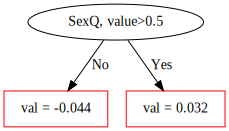

In [32]:
pool = Pool(X_train, y_train, feature_names=list(X_train.columns))
best_model.plot_tree(tree_idx=0, pool=pool)

In [33]:
# CREATING NEW FEATURE
catboost_new_feature = best_model.predict(X)

dfNew = pd.read_csv(data_path + 'trainData.csv')
dfNew['catBoost'] = chek_preds

pd.DataFrame(dfNew).to_csv(data_path + "trainDataNF.csv")


ValueError: Length of values (223) does not match length of index (891)

In [ ]:
# CREATING ANSWER
best_model.fit(X, y)
X_test_real = pd.read_csv('testData.csv')
y_pred_real = best_model.predict(X_test_real)


dfRealTest = pd.read_csv(data_path + "test.csv")
dfRealTest["Survived"] = y_pred_real
dfRealTest = dfRealTest[["PassengerId", "Survived"]]


dfRealTest = dfRealTest.set_index("PassengerId")
pd.DataFrame(dfRealTest).to_csv(data_path + "answer.csv")